In [1]:
!git clone https://github.com/facebookresearch/segment-anything.git
%cd segment-anything
!pip install -e .
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d sujansarkar/isic-2016-dataset
!unzip isic-2016-dataset.zip -d isic-2016-dataset

!kaggle datasets download -d kartikmaity/ph2-dataset-segmentation
!unzip ph2-dataset-segmentation.zip -d ph2-dataset-segmentation

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from segment_anything import sam_model_registry, SamPredictor
import random
from skimage import measure, exposure
from scipy.ndimage import binary_fill_holes
from skimage.measure import label, regionprops
from sklearn.metrics import jaccard_score
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.cuda.amp import autocast, GradScaler

try:
    import clip
except:
    !pip install git+https://github.com/openai/CLIP.git
    import clip

sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
predictor = SamPredictor(sam)

clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

support_images_dir = "isic-2016-dataset/ISIC_2016_dataset/ISIC_2016_dataset/ISBI2016_ISIC_Part1_Training_Data"
support_masks_dir  = "isic-2016-dataset/ISIC_2016_dataset/ISIC_2016_dataset/ISBI2016_ISIC_Part1_Training_GroundTruth"
query_images_dir   = "ph2-dataset-segmentation/Test/Images"
query_masks_dir    = "ph2-dataset-segmentation/Test/Masks"

output_masks_dir = "Kvasir-Capsule/predictor_masks"
os.makedirs(output_masks_dir, exist_ok=True)

Cloning into 'segment-anything'...
remote: Enumerating objects: 304, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 304 (delta 2), reused 2 (delta 2), pack-reused 299 (from 2)
Receiving objects: 100% (304/304), 18.31 MiB | 11.77 MiB/s, done.
Resolving deltas: 100% (159/159), done.
/content/segment-anything
Obtaining file:///content/segment-anything
  Preparing metadata (setup.py) ... done
  Running setup.py develop for segment_anything
--2025-10-19 17:44:33--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.90, 13.35.37.84, 13.35.37.123, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   287MB/s    in 1.2s

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/sujansarkar/isic-2016-dataset
License(s): unknown
 99% 931M/941M [00:05<00:00, 114MB/s]
100% 941M/941M [00:05<00:00, 194MB/s]
Archive:  isic-2016-dataset.zip
  inflating: isic-2016-dataset/ISIC_2016_dataset/ISIC_2016_dataset/ISBI2016_ISIC_Part1_Test_Data/ISIC_0000003.jpg  
  inflating: isic-2016-dataset/ISIC_2016_dataset/ISIC_2016_dataset/ISBI2016_ISIC_Part1_Test_Data/ISIC_0000012.jpg  
  inflating: isic-2016-dataset/ISIC_2016_dataset/ISIC_2016_dataset/ISBI2016_ISIC_Part1_Test_Data/ISIC_0000013.jpg  
  inflating: isic-2016-dataset/ISIC_2016_dataset/ISIC_2016_dataset/ISBI2016_ISIC_Part1_Test_Data/ISIC_0000014.jpg  
  inflating: isic-2016-dataset/ISIC_2016_dataset/ISIC_2016_dataset/ISBI2016_ISIC_Part1_Test_Data/ISIC_0000015.jpg  
  inflating: isic-2016-dataset/ISIC_2016_dataset/ISIC_2016_dataset/ISBI2016_ISIC_Part1_Test_Data/ISIC_0000020.jpg  
  inflating: isic-2016-dataset/ISIC_2016_dataset/ISIC_2016_dataset/

100%|███████████████████████████████████████| 338M/338M [00:11<00:00, 30.6MiB/s]


In [2]:
class TextPromptLearner(nn.Module):
    def __init__(self, n_ctx=16):
        super().__init__()
        self.n_ctx = n_ctx
        ctx_vectors = torch.empty(n_ctx, 512)
        nn.init.normal_(ctx_vectors, std=0.02)
        self.ctx = nn.Parameter(ctx_vectors)

    def forward(self, class_names=["Skin Cancer Cell"]):
        prompts = []
        for class_name in class_names:
            name_tokens = clip.tokenize([class_name]).to(self.ctx.device)
            text_features = clip_model.encode_text(name_tokens)
            ctx = self.ctx.unsqueeze(0)
            prompt = torch.cat([ctx, text_features.unsqueeze(1)], dim=1)
            prompts.append(prompt)
        return torch.cat(prompts, dim=0)

class MultiModalFusion(nn.Module):
    def __init__(self, vis_dim=256, text_dim=512, hidden_dim=512, num_heads=8):
        super().__init__()
        self.vis_proj = nn.Linear(vis_dim, hidden_dim)
        self.text_proj = nn.Linear(text_dim, hidden_dim)
        self.vis_to_text_attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=0.1, batch_first=True)
        self.text_to_vis_attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=0.1, batch_first=True)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.fusion = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.1)
        )

    def forward(self, vis_emb, text_emb):
        vis_proj = self.vis_proj(vis_emb).unsqueeze(1)
        text_proj = self.text_proj(text_emb).unsqueeze(1)
        vis_with_text, _ = self.vis_to_text_attention(query=vis_proj, key=text_proj, value=text_proj)
        vis_with_text = self.ln1(vis_proj + vis_with_text)
        text_with_vis, _ = self.text_to_vis_attention(query=text_proj, key=vis_proj, value=vis_proj)
        text_with_vis = self.ln2(text_proj + text_with_vis)
        fused = torch.cat([vis_with_text.squeeze(1), text_with_vis.squeeze(1)], dim=-1)
        return self.fusion(fused)

class EnhancedLearnablePromptGenerator(nn.Module):
    def __init__(self, img_emb_dim=256, mask_emb_dim=1, prompt_dim=512, dropout=0.2):
        super().__init__()
        self.text_prompt_learner = TextPromptLearner()
        self.cross_modal_fusion = MultiModalFusion(img_emb_dim, 512, prompt_dim)
        self.img_proj = nn.Linear(img_emb_dim, prompt_dim)
        self.mask_proj = nn.Linear(mask_emb_dim, prompt_dim)
        self.fc_in = nn.Linear(prompt_dim * 3, prompt_dim)
        self.ln1 = nn.LayerNorm(prompt_dim)
        self.attention = nn.MultiheadAttention(prompt_dim, num_heads=8, dropout=0.1, batch_first=True)
        self.fc_mid1 = nn.Sequential(
            nn.Linear(prompt_dim, prompt_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(prompt_dim, prompt_dim),
            nn.GELU(),
        )
        self.ln2 = nn.LayerNorm(prompt_dim)
        self.fc_mid2 = nn.Sequential(
            nn.Linear(prompt_dim, prompt_dim//2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(prompt_dim//2, prompt_dim//2),
            nn.GELU(),
        )
        self.fc_out = nn.Linear(prompt_dim//2, 5)
        nn.init.constant_(self.fc_out.bias, 0.0)
        nn.init.xavier_uniform_(self.fc_out.weight)

    def forward(self, img_emb, mask_emb, class_names=["Skin Cancer Cell"]):
        if img_emb.ndim > 2:
            img_emb = img_emb.mean(dim=(-2, -1))
        if mask_emb.ndim > 2:
            mask_emb = mask_emb.mean(dim=(-2, -1))
        text_prompts = self.text_prompt_learner(class_names)
        text_features = text_prompts.mean(dim=1)
        fused_features = self.cross_modal_fusion(img_emb, text_features)
        img_proj = self.img_proj(img_emb)
        mask_proj = self.mask_proj(mask_emb)
        x = torch.cat([fused_features, img_proj, mask_proj], dim=1)
        x = self.fc_in(x)
        x = self.ln1(x)
        x_attn, _ = self.attention(x.unsqueeze(1), x.unsqueeze(1), x.unsqueeze(1))
        x = x + x_attn.squeeze(1)
        res1 = self.fc_mid1(x)
        x = x + res1
        x = self.ln2(x)
        x = self.fc_mid2(x)
        box = torch.sigmoid(self.fc_out(x))
        cx = (box[:, 0] * 0.7) + 0.15
        cy = (box[:, 1] * 0.7) + 0.15
        w = (box[:, 2] * 0.4) + 0.2
        h = (box[:, 3] * 0.4) + 0.2
        conf = box[:, 4]
        x0 = (cx - w / 2).clamp(0.05, 0.95)
        y0 = (cy - h / 2).clamp(0.05, 0.95)
        x1 = (cx + w / 2).clamp(0.05, 0.95)
        y1 = (cy + h / 2).clamp(0.05, 0.95)
        box_xyxy = torch.stack([x0, y0, x1, y1], dim=1)
        return box_xyxy, conf

class AdaptiveMaskRefiner(nn.Module):
    def __init__(self, in_ch=4, base_ch=64):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
            )

        self.enc1 = conv_block(in_ch, base_ch)
        self.enc2 = conv_block(base_ch, base_ch*2)
        self.enc3 = conv_block(base_ch*2, base_ch*4)
        self.enc4 = conv_block(base_ch*4, base_ch*8)
        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(base_ch*8, base_ch*8)

        self.up4 = nn.ConvTranspose2d(base_ch*8, base_ch*8, 2, stride=2)
        self.dec4 = conv_block(base_ch*16, base_ch*8)

        self.up3 = nn.ConvTranspose2d(base_ch*8, base_ch*4, 2, stride=2)
        self.dec3 = conv_block(base_ch*8, base_ch*4)

        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 2, stride=2)
        self.dec2 = conv_block(base_ch*4, base_ch*2)

        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, 2, stride=2)
        self.dec1 = conv_block(base_ch*2, base_ch)

        self.final = nn.Sequential(
            nn.Conv2d(base_ch, base_ch//2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch//2, base_ch//4, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch//4, 1, 1)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b)
        d4 = F.interpolate(d4, size=e4.shape[2:], mode='bilinear', align_corners=False)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = F.interpolate(d3, size=e3.shape[2:], mode='bilinear', align_corners=False)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = F.interpolate(d2, size=e2.shape[2:], mode='bilinear', align_corners=False)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = F.interpolate(d1, size=e1.shape[2:], mode='bilinear', align_corners=False)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.final(d1)
        return torch.sigmoid(out)

support_files = [f for f in os.listdir(support_images_dir) if f.endswith(".jpg")]
random.seed(42)
support_samples = random.sample(support_files, 1)
supports=[]
for fname in support_samples:
    img_path = os.path.join(support_images_dir, fname)
    mask_name = fname.replace(".jpg", "_Segmentation.png")
    mask_path = os.path.join(support_masks_dir, mask_name)

    img = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"))
    supports.append({"fname":fname,"image":img,"mask":mask})
support_embeddings = []
for s in supports:
    predictor.set_image(s["image"])
    img_emb = predictor.get_image_embedding()
    mask_tensor = torch.tensor(s["mask"], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)/255.0
    mask_emb = F.interpolate(mask_tensor, size=(img_emb.shape[-2], img_emb.shape[-1]), mode='bilinear')
    support_embeddings.append({"img_emb": img_emb, "mask_emb": mask_emb, "fname": s["fname"]})
print("Selected supports:", [s['fname'] for s in supports])

query_files = [f for f in os.listdir(query_images_dir) if f.endswith(".bmp")]
query_files = sorted(query_files)[:8]

def postprocess_mask(bin_mask, min_cc_area=50):
    m = (bin_mask > 0).astype(np.uint8)
    if m.sum() == 0:
        return (m*255).astype(np.uint8)
    m = binary_fill_holes(m).astype(np.uint8)
    from skimage.morphology import disk, opening, closing
    selem_disk2 = disk(2)
    selem_disk3 = disk(3)
    m = opening(m, selem_disk2)
    m = closing(m, selem_disk3)
    lab = label(m)
    out = np.zeros_like(m)
    regions = regionprops(lab)
    if regions:
        regions = sorted(regions, key=lambda x: x.area, reverse=True)
        kept = 0
        for reg in regions:
            if reg.area >= min_cc_area and kept < 3:
                out[lab == reg.label] = 1
                kept += 1
    return (out * 255).astype(np.uint8)

def sam_predict_with_learned_prompt(predictor, query_img, learned_prompt, conf_score):
    predictor.set_image(query_img)
    h, w = query_img.shape[:2]
    if isinstance(learned_prompt, torch.Tensor):
        box_norm = learned_prompt.detach().cpu().numpy().reshape(-1)
    else:
        box_norm = np.array(learned_prompt).reshape(-1)

    x0 = int((box_norm[0]) * w)
    y0 = int((box_norm[1]) * h)
    x1 = int((box_norm[2]) * w)
    y1 = int((box_norm[3]) * h)

    x0, x1 = max(0, min(x0, w-1)), max(0, min(x1, w-1))
    y0, y1 = max(0, min(y0, h-1)), max(0, min(y1, h-1))

    if x1 - x0 < 15:
        x0, x1 = max(0, x0-15), min(w-1, x1+15)
    if y1 - y0 < 15:
        y0, y1 = max(0, y0-15), min(h-1, y1+15)

    box_pixels = np.array([x0, y0, x1, y1])

    try:
        masks, scores, logits = predictor.predict(box=box_pixels, multimask_output=True)

        if conf_score < 0.4:
            center_x, center_y = (x0 + x1) // 2, (y0 + y1) // 2
            pts = np.array([[center_x, center_y]])
            masks_pts, scores_pts, _ = predictor.predict(point_coords=pts, point_labels=np.ones(len(pts)), multimask_output=False)
            if masks_pts is not None and masks_pts.size>0:
                mask = masks_pts[0]
                return postprocess_mask(mask.astype(np.uint8))

        if masks.size == 0 or np.max(scores) < 0.05:
            center_x, center_y = (x0 + x1) // 2, (y0 + y1) // 2
            pts = np.array([[center_x, center_y]])
            masks_pts, scores_pts, _ = predictor.predict(point_coords=pts, point_labels=np.ones(len(pts)), multimask_output=False)
            if masks_pts is not None and masks_pts.size>0:
                mask = masks_pts[0]
                return postprocess_mask(mask.astype(np.uint8))
            return np.zeros((h, w), dtype=np.uint8)

        best_idx = np.argmax(scores)
        mask = masks[best_idx]

        if scores[best_idx] < 0.4:
            center_x, center_y = (x0 + x1) // 2, (y0 + y1) // 2
            pts = np.array([[center_x, center_y]])
            masks_pts, scores_pts, _ = predictor.predict(point_coords=pts, point_labels=np.ones(len(pts)), multimask_output=False)
            if masks_pts is not None and masks_pts.size>0 and scores_pts[0] > scores[best_idx]:
                mask = masks_pts[0]

        return postprocess_mask(mask.astype(np.uint8))
    except Exception as e:
        print("SAM predict error:", e)
        return np.zeros((h, w), dtype=np.uint8)

def augment_image_and_mask(img_np, mask_np):
    img = Image.fromarray(img_np)
    mask = Image.fromarray(mask_np)
    if random.random() > 0.5:
        img = TF.hflip(img)
        mask = TF.hflip(mask)
    if random.random() > 0.5:
        img = TF.vflip(img)
        mask = TF.vflip(mask)
    rot = random.choice([0,90,180,270])
    if rot:
        img = TF.rotate(img, rot)
        mask = TF.rotate(mask, rot)
    if random.random() < 0.8:
        b = np.random.uniform(0.7, 1.3)
        c = np.random.uniform(0.7, 1.3)
        s = np.random.uniform(0.8, 1.2)
        img = TF.adjust_brightness(img, b)
        img = TF.adjust_contrast(img, c)
        img = TF.adjust_saturation(img, s)
    if random.random() < 0.2:
        img = TF.gaussian_blur(img, kernel_size=3)
    return np.array(img), np.array(mask)

def compute_learned_prompt(query_img, support_embeddings, lpg, predictor):
    predictor.set_image(query_img)
    with torch.no_grad():
        query_emb = predictor.get_image_embedding()
    query_flat = query_emb.mean(dim=(-2, -1))

    all_prompts = []
    all_confs = []
    sim_scores = []

    for s in support_embeddings:
        s_img_emb = s["img_emb"].to(query_flat.device)
        s_mask_emb = s["mask_emb"].to(query_flat.device)
        s_img_flat = s_img_emb.mean(dim=(-2, -1))

        prompt, conf = lpg(s_img_flat, s_mask_emb.mean(dim=(-2,-1)), class_names=["Skin Cancer Cell"])
        all_prompts.append(prompt)
        all_confs.append(conf)

        sim = F.cosine_similarity(query_flat, s_img_flat, dim=1)
        sim_scores.append(sim)

    sims = torch.cat(sim_scores, dim=0)
    if sims.sum() <= 0:
        weights = torch.ones_like(sims) / len(sims)
    else:
        weights = F.softmax(sims / 0.05, dim=0)

    learned_prompt = sum(w.unsqueeze(0) * p for w, p in zip(weights, all_prompts))
    learned_conf = sum(w.unsqueeze(0) * c for w, c in zip(weights, all_confs))

    return learned_prompt, learned_conf

def enhanced_loss(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred_sig = torch.sigmoid(pred)
    smooth = 1e-6
    intersection = (pred_sig * target).sum(dim=(2,3))
    union = pred_sig.sum(dim=(2,3)) + target.sum(dim=(2,3)) + smooth
    dice = 1.0 - (2. * intersection + smooth) / (union + smooth)

    return 0.4 * bce + 0.6 * dice.mean()

Selected supports: ['ISIC_0009944.jpg']


Selected supports: ['ISIC_0009944.jpg']
Query files: ['IMD004.bmp', 'IMD010.bmp', 'IMD016.bmp', 'IMD031.bmp', 'IMD042.bmp', 'IMD044.bmp', 'IMD048.bmp', 'IMD049.bmp']
Epoch 1/20 | Loss: 0.7124 | SAM succ: 8/8 | Dice: 0.6076
Saved best checkpoint.
Epoch 2/20 | Loss: 0.6328 | SAM succ: 8/8 | Dice: 0.7559
Saved best checkpoint.
Epoch 3/20 | Loss: 0.6282 | SAM succ: 8/8 | Dice: 0.8180
Saved best checkpoint.
Epoch 4/20 | Loss: 0.6212 | SAM succ: 8/8 | Dice: 0.6234
Epoch 5/20 | Loss: 0.6208 | SAM succ: 8/8 | Dice: 0.7783
Epoch 6/20 | Loss: 0.6456 | SAM succ: 8/8 | Dice: 0.8257
Saved best checkpoint.
Epoch 7/20 | Loss: 0.6358 | SAM succ: 8/8 | Dice: 0.8515
Saved best checkpoint.
Epoch 8/20 | Loss: 0.6116 | SAM succ: 8/8 | Dice: 0.8384
Epoch 9/20 | Loss: 0.6087 | SAM succ: 8/8 | Dice: 0.8601
Saved best checkpoint.
Epoch 10/20 | Loss: 0.6150 | SAM succ: 8/8 | Dice: 0.8492
Epoch 11/20 | Loss: 0.6242 | SAM succ: 8/8 | Dice: 0.8788
Saved best checkpoint.
Epoch 12/20 | Loss: 0.6203 | SAM succ: 8/8 |

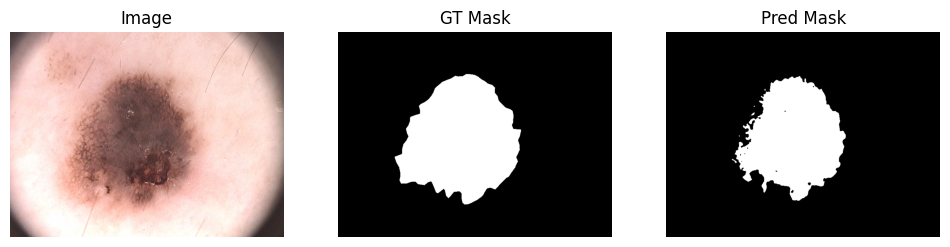

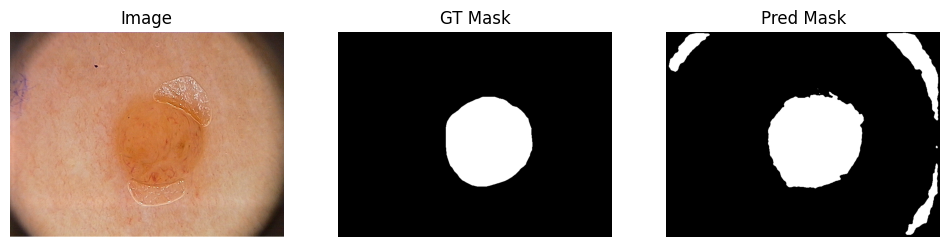

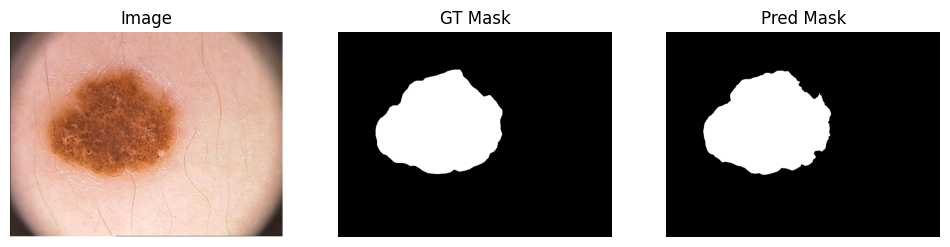

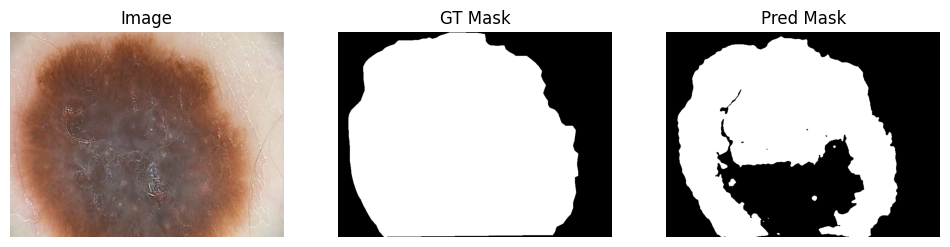

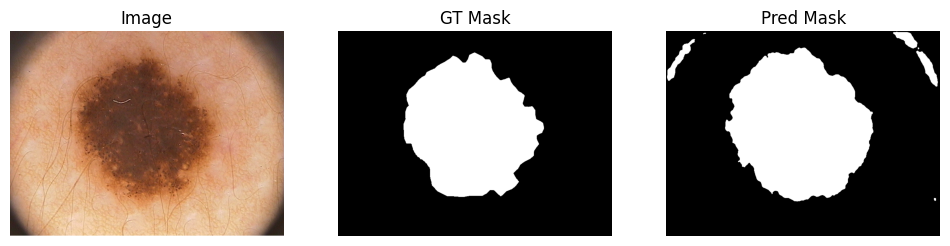

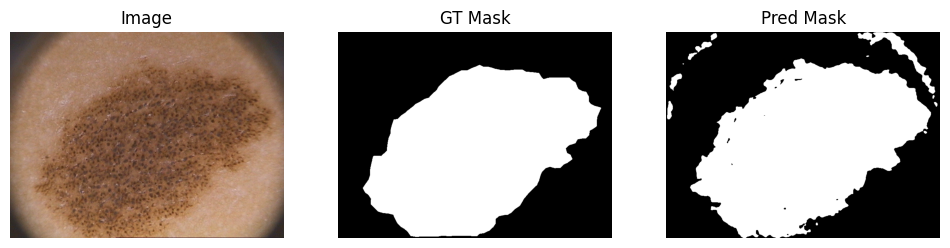

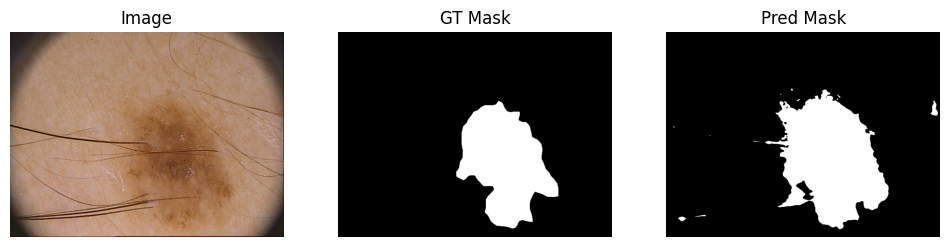

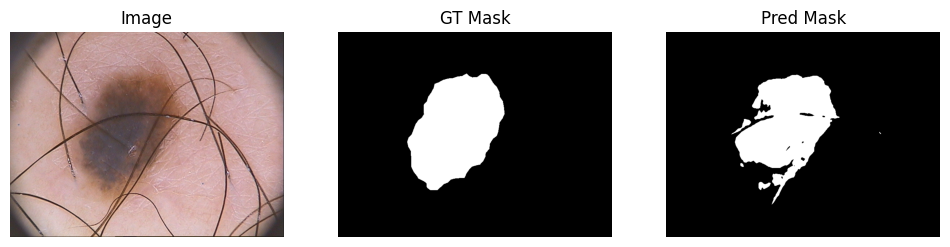

In [3]:
support_files = [f for f in os.listdir(support_images_dir) if f.endswith(".jpg")]
random.seed(42)
support_samples = random.sample(support_files, 1)
supports=[]
for fname in support_samples:
    img_path = os.path.join(support_images_dir, fname)
    mask_name = fname.replace(".jpg", "_Segmentation.png")
    mask_path = os.path.join(support_masks_dir, mask_name)

    img = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"))
    supports.append({"fname":fname,"image":img,"mask":mask})
support_embeddings = []
for s in supports:
    predictor.set_image(s["image"])
    img_emb = predictor.get_image_embedding()
    mask_tensor = torch.tensor(s["mask"], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)/255.0
    mask_emb = F.interpolate(mask_tensor, size=(img_emb.shape[-2], img_emb.shape[-1]), mode='bilinear')
    support_embeddings.append({"img_emb": img_emb, "mask_emb": mask_emb, "fname": s["fname"]})
print("Selected supports:", [s['fname'] for s in supports])

query_files = [f for f in os.listdir(query_images_dir) if f.endswith(".bmp")]
query_files = sorted(query_files)[:8]
print("Query files:", query_files)

lpg = EnhancedLearnablePromptGenerator().to(device)
refiner = AdaptiveMaskRefiner().to(device)

optimizer = torch.optim.AdamW([
    {'params': lpg.parameters(), 'lr': 2e-3},
    {'params': refiner.parameters(), 'lr': 2e-3}
], weight_decay=1e-4)

scaler = torch.amp.GradScaler('cuda') if device == 'cuda' else None
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)
best_dice = 0.0
num_epochs = 20
val_query_files = query_files[:]

for epoch in range(num_epochs):
    lpg.train()
    refiner.train()
    total_loss = 0.0
    succ = 0

    for fname in query_files:
        q_img_path = os.path.join(query_images_dir, fname)
        mask_name = fname.replace(".bmp", "_lesion.bmp")
        gt_mask_path = os.path.join(query_masks_dir, mask_name)

        q_img = np.array(Image.open(q_img_path).convert("RGB"))
        gt_mask = np.array(Image.open(gt_mask_path).convert("L"))

        q_img_aug, gt_mask_aug = augment_image_and_mask(q_img, gt_mask)
        predictor.set_image(q_img_aug)
        q_tensor = torch.tensor(q_img_aug.transpose(2,0,1), dtype=torch.float32).unsqueeze(0).to(device)/255.0

        learned_prompt, learned_conf = compute_learned_prompt(q_img_aug, support_embeddings, lpg, predictor)

        mask_sam = sam_predict_with_learned_prompt(predictor, q_img_aug, learned_prompt, learned_conf.item())
        if mask_sam.sum() > 0:
            succ += 1

        mask_sam_t = torch.tensor(mask_sam, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)/255.0
        mask_sam_t = F.interpolate(mask_sam_t, size=(q_tensor.shape[2], q_tensor.shape[3]), mode='bilinear')

        optimizer.zero_grad()
        if device == 'cuda':
            with torch.amp.autocast('cuda'):
                refined = refiner(torch.cat([q_tensor, mask_sam_t], dim=1))
                gt_resized = np.array(Image.fromarray(gt_mask_aug).resize((refined.shape[3], refined.shape[2]), Image.BILINEAR))
                gt_t = torch.tensor(gt_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)/255.0
                loss = enhanced_loss(refined, gt_t)
        else:
            refined = refiner(torch.cat([q_tensor, mask_sam_t], dim=1))
            gt_resized = np.array(Image.fromarray(gt_mask_aug).resize((refined.shape[3], refined.shape[2]), Image.BILINEAR))
            gt_t = torch.tensor(gt_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)/255.0
            loss = enhanced_loss(refined, gt_t)

        if scaler:
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(list(lpg.parameters())+list(refiner.parameters()), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(list(lpg.parameters())+list(refiner.parameters()), max_norm=1.0)
            optimizer.step()

        total_loss += loss.item()

    if len(query_files) > 0:
        avg_loss = total_loss / len(query_files)
    else:
        avg_loss = 0.0

    scheduler.step()

    lpg.eval()
    refiner.eval()
    all_gt, all_pred = [], []
    with torch.no_grad():
        for fname in val_query_files:
            q_img_path = os.path.join(query_images_dir, fname)
            mask_name = fname.replace(".bmp", "_lesion.bmp")
            gt_mask_path = os.path.join(query_masks_dir, mask_name)

            q_img = np.array(Image.open(q_img_path).convert("RGB"))
            gt_mask = np.array(Image.open(gt_mask_path).convert("L"))
            predictor.set_image(q_img)
            learned_prompt, learned_conf = compute_learned_prompt(q_img, support_embeddings, lpg, predictor)
            mask_sam = sam_predict_with_learned_prompt(predictor, q_img, learned_prompt, learned_conf.item())
            mask_sam_t = torch.tensor(mask_sam, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)/255.0
            q_tensor = torch.tensor(q_img.transpose(2,0,1), dtype=torch.float32).unsqueeze(0).to(device)/255.0
            refined = refiner(torch.cat([q_tensor, F.interpolate(mask_sam_t, size=(q_tensor.shape[2], q_tensor.shape[3]), mode='bilinear')], dim=1))
            pred_np = (refined[0,0].cpu().numpy()>0.5).astype(np.uint8)
            gt_res = np.array(Image.fromarray(gt_mask).resize(pred_np.shape[::-1], Image.BILINEAR))
            all_gt.append((gt_res>127).astype(np.uint8).flatten())
            all_pred.append(pred_np.flatten())

    if all_gt and all_pred:
        all_gt = np.concatenate(all_gt)
        all_pred = np.concatenate(all_pred)
        inter = (all_gt & all_pred).sum()
        dice = (2*inter) / (all_gt.sum() + all_pred.sum() + 1e-6)
    else:
        dice = 0.0

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | SAM succ: {succ}/{len(query_files)} | Dice: {dice:.4f}")

    if dice > best_dice:
        best_dice = dice
        torch.save({
            'lpg': lpg.state_dict(),
            'refiner': refiner.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch
        }, "best_lpg_refiner.pth")
        print("Saved best checkpoint.")

if os.path.exists("best_lpg_refiner.pth"):
    checkpoint = torch.load("best_lpg_refiner.pth")
    lpg.load_state_dict(checkpoint['lpg'])
    refiner.load_state_dict(checkpoint['refiner'])

lpg.eval()
refiner.eval()

for fname in query_files:
    q_img_path = os.path.join(query_images_dir, fname)
    mask_name = fname.replace(".bmp", "_lesion.bmp")
    gt_mask_path = os.path.join(query_masks_dir, mask_name)

    q_img = np.array(Image.open(q_img_path).convert("RGB"))
    gt_mask = np.array(Image.open(gt_mask_path).convert("L"))

    predictor.set_image(q_img)
    learned_prompt, learned_conf = compute_learned_prompt(q_img, support_embeddings, lpg, predictor)
    mask_sam = sam_predict_with_learned_prompt(predictor, q_img, learned_prompt, learned_conf.item())

    mask_sam_t = torch.tensor(mask_sam, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)/255.0
    q_tensor = torch.tensor(q_img.transpose(2,0,1), dtype=torch.float32).unsqueeze(0).to(device)/255.0
    mask_sam_t = F.interpolate(mask_sam_t, size=(q_tensor.shape[2], q_tensor.shape[3]), mode='bilinear')

    with torch.no_grad():
        refined = refiner(torch.cat([q_tensor, mask_sam_t], dim=1))
        pred_np = (refined[0,0].cpu().numpy() > 0.5).astype(np.uint8) * 255

    Image.fromarray(pred_np).save(os.path.join(output_masks_dir, fname))

all_gt = []
all_pred = []

for fname in query_files:
    mask_name = fname.replace(".bmp", "_lesion.bmp")
    gt_mask_path = os.path.join(query_masks_dir, mask_name)
    pred_mask_path = os.path.join(output_masks_dir, fname)

    gt_mask = np.array(Image.open(gt_mask_path).convert("L"))
    pred_mask = np.array(Image.open(pred_mask_path))
    all_gt.append((gt_mask>127).astype(np.uint8))
    all_pred.append((pred_mask>127).astype(np.uint8))

if all_gt and all_pred:
    all_gt_flat = np.concatenate([g.flatten() for g in all_gt])
    all_pred_flat = np.concatenate([p.flatten() for p in all_pred])

    intersection = (all_gt_flat & all_pred_flat).sum()
    union = all_gt_flat.sum() + all_pred_flat.sum()
    dice_combined = (2*intersection) / (union + 1e-6)
    iou_combined = intersection / (all_gt_flat.sum() + all_pred_flat.sum() - intersection + 1e-6)

    print(f"Final Combined Dice: {dice_combined:.4f}, Combined IoU: {iou_combined:.4f}")
else:
    print("No predictions to evaluate")

for fname in query_files:
    q_img_path = os.path.join(query_images_dir, fname)
    mask_name = fname.replace(".bmp", "_lesion.bmp")
    gt_mask_path = os.path.join(query_masks_dir, mask_name)
    pred_mask_path = os.path.join(output_masks_dir, fname)

    q_img = np.array(Image.open(q_img_path).convert("RGB"))
    gt_mask = np.array(Image.open(gt_mask_path).convert("L"))
    pred_mask = np.array(Image.open(pred_mask_path))

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(q_img)
    plt.axis('off')
    plt.title("Image")

    plt.subplot(1,3,2)
    plt.imshow(gt_mask, cmap='gray')
    plt.axis('off')
    plt.title("GT Mask")

    plt.subplot(1,3,3)
    plt.imshow(pred_mask, cmap='gray')
    plt.axis('off')
    plt.title("Pred Mask")

    plt.show()